In [1]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [2]:
import json
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

[I 2025-02-20 09:15:56,852] A new study created in memory with name: no-name-6f88972b-41ff-4ddd-b3e1-4def36097575
[I 2025-02-20 09:15:56,855] Trial 0 finished with value: 0.0 and parameters: {'y': 0.9473684210526315, 'x': 0.0}. Best is trial 0 with value: 0.0.
[I 2025-02-20 09:15:56,856] Trial 1 finished with value: 0.23391812865497075 and parameters: {'y': 0.5263157894736842, 'x': 0.8888888888888888}. Best is trial 0 with value: 0.0.
[I 2025-02-20 09:15:56,857] Trial 2 finished with value: 0.1023391812865497 and parameters: {'y': 0.3684210526315789, 'x': 0.5555555555555556}. Best is trial 0 with value: 0.0.
[I 2025-02-20 09:15:56,858] Trial 3 finished with value: 0.21052631578947367 and parameters: {'y': 0.9473684210526315, 'x': 0.4444444444444444}. Best is trial 0 with value: 0.0.
[I 2025-02-20 09:15:56,859] Trial 4 finished with value: 0.3976608187134502 and parameters: {'y': 0.894736842105263, 'x': 0.8888888888888888}. Best is trial 0 with value: 0.0.
[I 2025-02-20 09:15:56,860] Tr

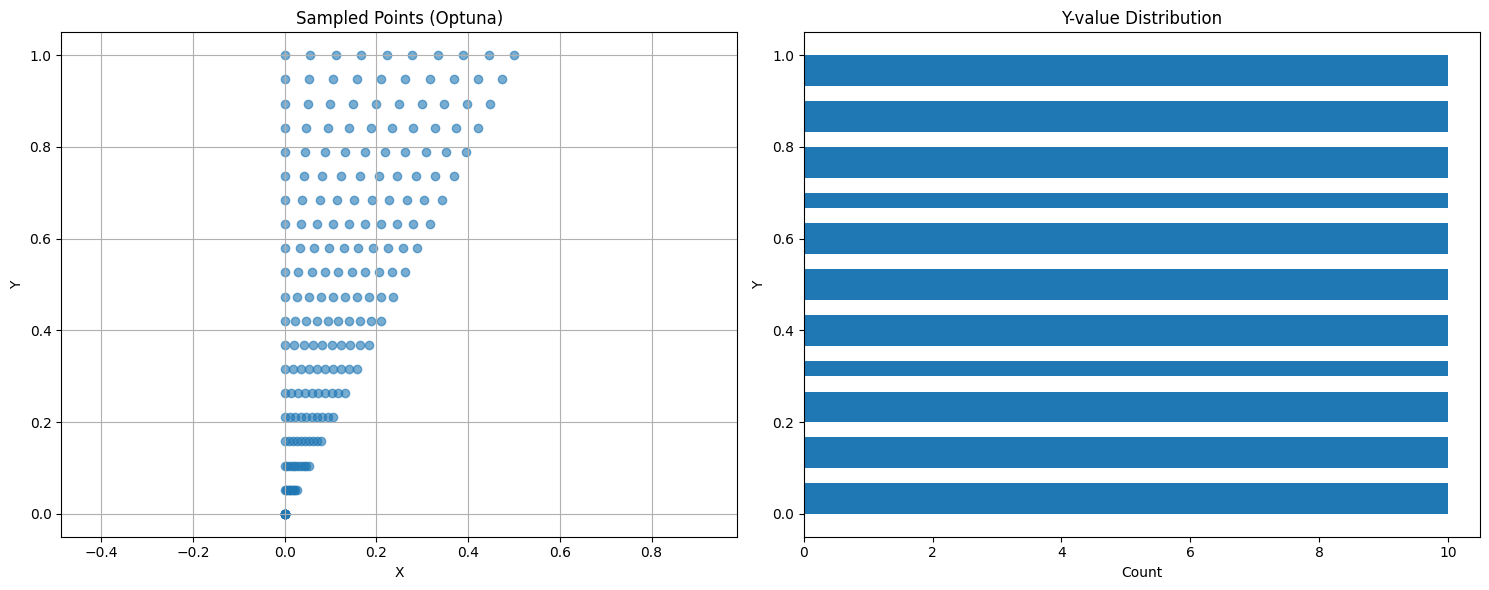

Number of points: 200


In [32]:
import optuna

def define_triangle_search_space(trial):
    """
    Define a search space for points in right triangle above y=x using Optuna.
    
    Args:
        trial: Optuna trial object
    Returns:
        Tuple (x, y) representing a point in the triangle
    """
    # First sample y uniformly
    y = trial.suggest_float("y", 0.0, 1.0)
    
    # Then sample x uniformly between 0 and y
    x = trial.suggest_float("x", 0.0, 1.0)

    x = x * (y / 2)
    
    return x

# Example usage with visualization
n_trials = 210 # Adjust this for desired density
sampler = optuna.samplers.GridSampler(
    search_space={"x": np.linspace(0, 1, 10), "y": np.linspace(0, 1, 20)}
)
study = optuna.create_study(sampler=sampler)

study.optimize(define_triangle_search_space, n_trials=n_trials)  # Dummy objective function

# Extract points from study
points = np.array([[trial.value, trial.params['y']] 
                  for trial in study.trials])

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the points
ax1.scatter(points[:, 0], points[:, 1], alpha=0.6)
ax1.set_title('Sampled Points (Optuna)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.axis('equal')
ax1.grid(True)

# Plot y-value histogram
ax2.hist(points[:, 1], bins=30, orientation='horizontal')
ax2.set_ylabel('Y')
ax2.set_xlabel('Count')
ax2.set_title('Y-value Distribution')

plt.tight_layout()
plt.show()

# Print number of points
print(f"Number of points: {len(points)}")

In [5]:
OUT_DIR = Path("output/mix_rate_lb_sweep/2025-02-19_12-18-14") #  2025-02-19_03-34-58
RESULTS_DIR = Path("results/mix_rate_lb_sweep")
os.makedirs(RESULTS_DIR, exist_ok=True)

In [6]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = ["toy_grid", "fmnist_mnist", "cifar_mnist", "waterbirds"]

In [7]:
def get_study_name(ds_name, mix_rate):
    return f"{ds_name}_{mix_rate}"

In [7]:
# so right now I want to do some exploratory analysis
# for example, for a given dataset and mix rate, plot the max source acc counter grid 
# load all metrics in output/cc_mix_rate_lower_bound_sweep into a dataframe 
results = []
for study_dir in Path(OUT_DIR).iterdir():
    if not study_dir.is_dir():
        continue
    for exp_dir in study_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        metric_file = exp_dir / "metrics.json"
        config_file = exp_dir / "config.yaml"
        if not metric_file.exists(): 
            print(f"No metrics file found for {exp_dir}")
            continue
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)
        
        min_val_loss_idx = np.argmin(metrics["val_loss"])

        min_val_loss = metrics["val_loss"][min_val_loss_idx]

        source_acc_0 = metrics["val_source_acc_0"][min_val_loss_idx]
        source_acc_1 = metrics["val_source_acc_1"][min_val_loss_idx]
        max_source_acc = max(source_acc_0, source_acc_1)

        target_acc_0 = metrics["val_target_acc_0"][min_val_loss_idx]
        target_acc_1 = metrics["val_target_acc_1"][min_val_loss_idx]
        max_target_acc = max(target_acc_0, target_acc_1)

        test_acc_0 = metrics["test_acc_0"][min_val_loss_idx]
        test_acc_1 = metrics["test_acc_1"][min_val_loss_idx]
        max_test_acc = max(test_acc_0, test_acc_1)
        
       
        # Create a dictionary for each experiment
        result_dict = {
            'dataset': config["dataset"],
            'mix_rate': config["mix_rate"],
            'mix_rate_lb_01': config["mix_rate_lower_bound_01"],
            'mix_rate_lb_10': config["mix_rate_lower_bound_10"],
            'source_acc': max_source_acc,
            'target_acc': max_target_acc,
            'test_acc': max_test_acc,
            'study_dir': str(study_dir),
            'exp_dir': str(exp_dir)
        }
        results.append(result_dict)

df = pd.DataFrame(results)
df.to_csv(RESULTS_DIR / "mix_rate_lb_sweep_results.csv", index=False)

In [ ]:
df = pd.read_csv(RESULTS_DIR / "mix_rate_lb_sweep_results.csv")

In [11]:
def plot_mix_rate_accuracy(df, dataset, mix_rate, figsize=(10, 8), vmin=0.5, vmax=1.0):
    """
    Plot scatter of max source accuracy for given dataset and mix rate.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to plot
        mix_rate: float, mix rate to plot
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    
    # Filter data for specific dataset and mix rate
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    scatter = plt.scatter(
        data['mix_rate_lb_01'], 
        data['mix_rate_lb_01'] + data['mix_rate_lb_10'], 
        c=data['source_acc'],
        cmap='viridis',
        vmin=vmin,  # Set minimum value for color scale
        vmax=vmax,  # Set maximum value for color scale
        s=100  # Point size
    )
    
    # Add colorbar
    plt.colorbar(scatter, label='Max Source Accuracy')
    
    # Labels and title
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'Max Source Accuracy\nDataset: {dataset}, Mix Rate: {mix_rate}')
    
    # plt.tight_layout()
    plt.show()

In [12]:
# get max mix rate lb 01 for each dataset 
df.groupby('dataset')['mix_rate_lb_01'].max()

dataset
cifar_mnist     0.482326
fmnist_mnist    0.478141
toy_grid        0.478141
waterbirds      0.486745
Name: mix_rate_lb_01, dtype: float64

In [13]:
# get number of trials in each dataset mix rate combo 
df.groupby(['dataset', 'mix_rate']).size()

dataset       mix_rate
cifar_mnist   0.10        243
              0.25        243
              0.50        243
              0.75        243
              1.00        243
fmnist_mnist  0.10        243
              0.25        243
              0.50        243
              0.75        243
              1.00        243
toy_grid      0.10        243
              0.25        243
              0.50        243
              0.75        243
              1.00        243
waterbirds    0.10        243
              0.25        243
              0.50        243
              0.75        243
              1.00        243
dtype: int64

In [16]:
# get min and max source acc for each dataset 
df.groupby('dataset')['source_acc'].min(), df.groupby('dataset')['source_acc'].max()

(dataset
 cifar_mnist     0.632812
 fmnist_mnist    0.519531
 toy_grid        0.597656
 waterbirds      0.814655
 Name: source_acc, dtype: float64,
 dataset
 cifar_mnist     1.000000
 fmnist_mnist    1.000000
 toy_grid        1.000000
 waterbirds      0.992457
 Name: source_acc, dtype: float64)

/tmp/ipykernel_289969/691865286.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars


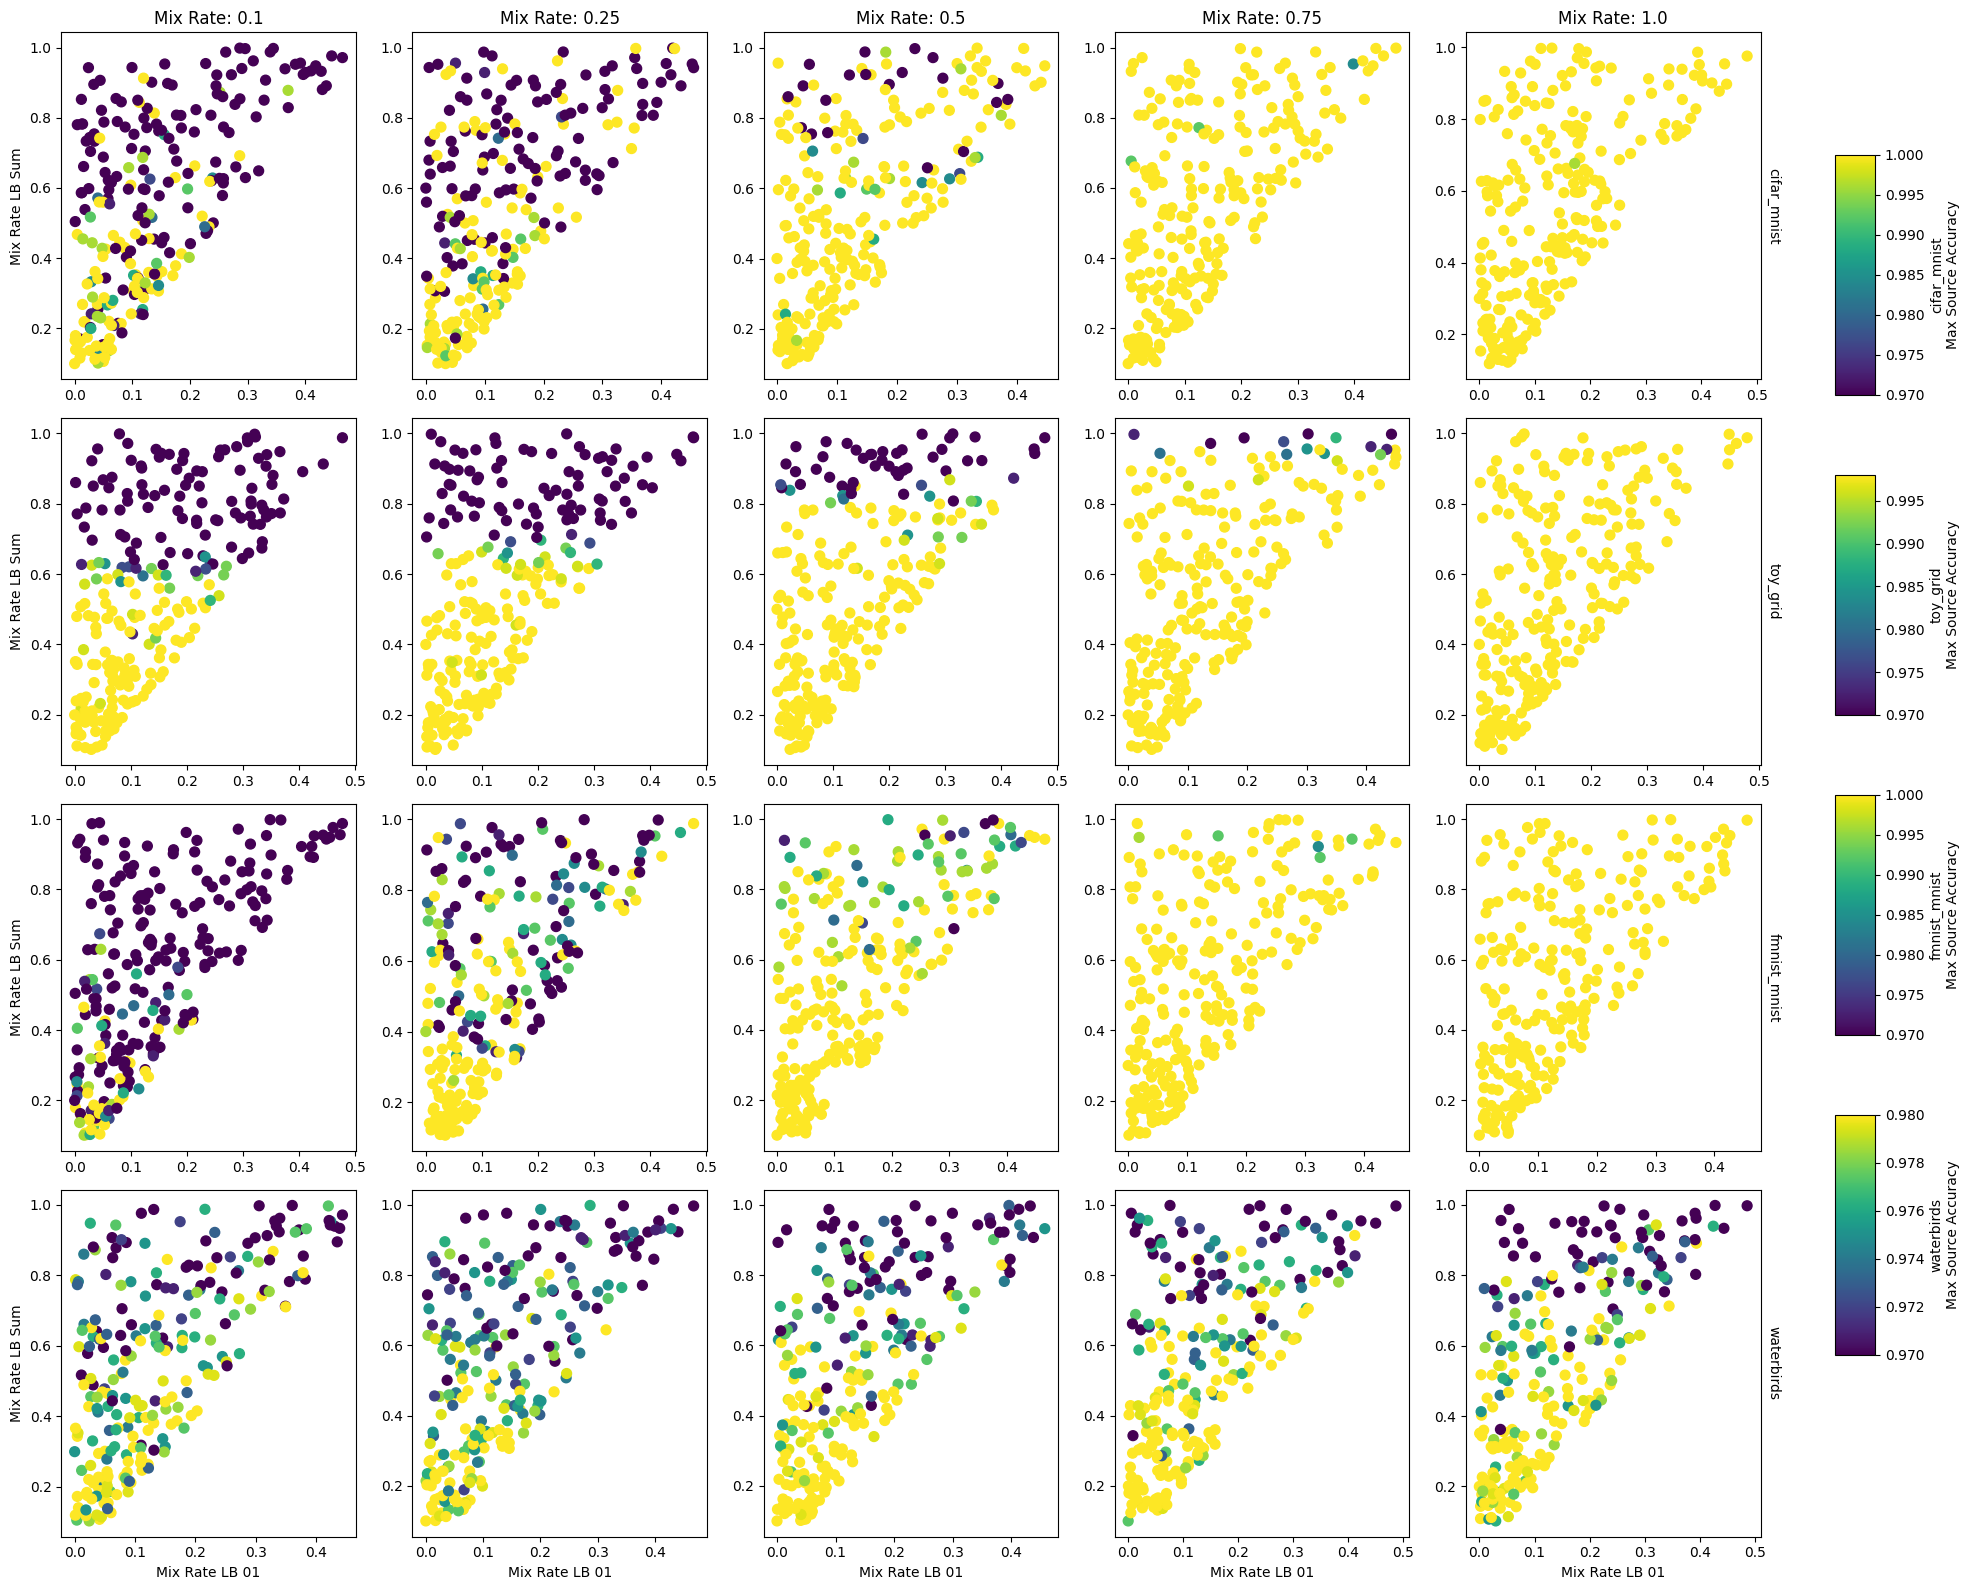

In [18]:
def plot_mix_rate_accuracy_grid(df, datasets, mix_rates, vmins=None, vmaxs=None):
    """
    Plot grid of scatter plots showing max source accuracy for all datasets and mix rates.
    
    Args:
        df: DataFrame containing the results
        datasets: list of dataset names to plot
        mix_rates: list of mix rates to plot
        vmins: dict mapping dataset names to min values for color scale, or float for all datasets
        vmaxs: dict mapping dataset names to max values for color scale, or float for all datasets
    """
    # Handle default vmin/vmax values
    if vmins is None:
        vmins = {dataset: 0.5 for dataset in datasets}
    elif isinstance(vmins, (int, float)):
        vmins = {dataset: vmins for dataset in datasets}
        
    if vmaxs is None:
        vmaxs = {dataset: 1.0 for dataset in datasets}
    elif isinstance(vmaxs, (int, float)):
        vmaxs = {dataset: vmaxs for dataset in datasets}
    
    # Create subplot grid
    n_rows = len(datasets)
    n_cols = len(mix_rates)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    
    # Store scatter plot objects for colorbars
    scatter_plots = {}
    
    # Iterate through datasets and mix rates
    for i, dataset in enumerate(datasets):
        for j, mix_rate in enumerate(mix_rates):
            ax = axes[i, j]
            
            # Filter data
            mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
            data = df[mask]
            
            if len(data) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
                continue
            
            # Create scatter plot
            scatter = ax.scatter(
                data['mix_rate_lb_01'], 
                data['mix_rate_lb_01'] + data['mix_rate_lb_10'], 
                c=data['source_acc'],
                cmap='viridis',
                vmin=vmins[dataset],
                vmax=vmaxs[dataset],
                s=50  # Reduced point size for grid layout
            )
            
            # Store scatter plot object for colorbar
            if j == n_cols - 1:  # Only for last column
                scatter_plots[dataset] = scatter
            
            # Add labels
            if i == len(datasets)-1:  # Only bottom row
                ax.set_xlabel('Mix Rate LB 01')
            if j == 0:  # Only leftmost column
                ax.set_ylabel('Mix Rate LB Sum')
            
            # Add title for top row only
            if i == 0:
                ax.set_title(f'Mix Rate: {mix_rate}')
            
            # Add dataset name on right side
            if j == len(mix_rates)-1:
                ax.text(1.02, 0.5, dataset, rotation=-90,
                       transform=ax.transAxes, va='center')
    
    # Add colorbars for each dataset on the right
    for i, (dataset, scatter) in enumerate(scatter_plots.items()):
        cax = fig.add_axes([0.92, 0.75 - (i * 0.2), 0.02, 0.15])  # [x, y, width, height]
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label(f'{dataset}\nMax Source Accuracy')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars
    plt.show()

# Example usage with different ranges for each dataset:
plot_mix_rate_accuracy_grid(
    df,
    datasets=['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds'],
    mix_rates=[0.1, 0.25, 0.5, 0.75, 1.0],
    vmins={'cifar_mnist': 0.97, 'toy_grid': 0.97, 'fmnist_mnist': 0.97, 'waterbirds': 0.97},
    vmaxs={'cifar_mnist': 1.0, 'toy_grid': 0.998, 'fmnist_mnist': 1.0, 'waterbirds': 0.98}
)

In [ ]:
mean_source_accs = {
    'celebA-0': 0.996,
    'cifar_mnist': 1.0,
    'fmnist_mnist': 1.0,
    'toy_grid': 0.999,
    'waterbirds': 0.984
}

std_source_accs = {
    'celebA-0': 0.0,
    'cifar_mnist': 0.0,
    'fmnist_mnist': 0.0,
    'toy_grid': 0.002,
    'waterbirds': 0.004
}

ok thoughts based on conversation with Ben 


- maybe do grid search so averaging over points makes more sense 
- instead of picking a fixed point, could use all the models in a weighted ensemble, weight exponentially decaying by standard deviations away from ERM


ok and then the "seed" population can be in some sense informed by the prior (so can make the seeds uniform)

- with an automatic procedure, could also test performance on datasets with randomly sampled mix rates (but in practice we could just do 0.1-1 at intervals of 0.1) 
- the key is using no human in the loop who knows about the mix rate